# Banana World Navigation

---

This is the first project in the Udacity [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893), in which the [Deep Q-Network (DQN) algorithm](https://arxiv.org/abs/1312.5602) is used to solve a simple "Banana Collector" game in a [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents) simulation environment.

### 1. Import Dependencies

We begin by importing some necessary packages.

In [9]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque, namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from unityagents import UnityEnvironment

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment. At each time step, there are 4 possible actions to take:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

The section below will display some information about the environment.

In [10]:
# Instantiate the environment
# NOTE: You should change your `env_file` variable below as needed
env_file = "/home/sebastian/udacity_drl/drlnd-navigation-project/Banana_Linux/Banana.x86_64"
env = UnityEnvironment(file_name=env_file)

# Get the first "brain" available from the environment
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# Reset the environment and collect information
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Action size:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
state_size = len(state)
print('State size:', state_size)
print('Initial state value:', state)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Action size: 4
State size: 37
Initial state value: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]


### 3. Take Random Actions in the Environment

In this section, we will test the simulation with an "agent" that selects an action randomly from a uniform distribution. 

We will use the final reward collected as a benchmark to see if we can do better by training an agent using reinforcement learning (spoiler alert: we can).

In [12]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
random_score = 0                                   # initialize the score

done = False
while not done:
    action = np.random.randint(action_size)        # select an action at random
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    random_score += reward                         # update the score
    state = next_state                             # roll over the state to next time step
    
print("Score with random actions: {}".format(random_score))

Score with random actions: 2.0


### 4. Build and Train a Deep Q-Network (DQN) Agent

#### 4a. Create a Q-Network

First we will define a Q-Network model architecture. This neural network will be our trainable function approximator that accepts a state as input and returns an estimate of the state-action value (or Q) for that state.

In [4]:
class QNetwork(nn.Module):
    """
    Defines a neural network to estimate the state-action value (Q) given an input state.
    """
    
    def __init__(self, num_states=37, num_actions=4, layer_dims=[128, 64, 32]):
        """
        Initialize the Q-Network structure
        
        """
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(num_states, layer_dims[0])
        self.fc2 = nn.Linear(layer_dims[0], layer_dims[1])
        self.fc3 = nn.Linear(layer_dims[1], layer_dims[2])
        self.fc4 = nn.Linear(layer_dims[2], num_actions)
        
        
    def forward(self, state):
        """ 
        Forward pass through the Q-Network, which accepts a state (array_like)
        and returns state-action values (float) for each action.
        """
        
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

#### 4b. Create a DQN Agent

Now, we will create a DQN Agent that can train the Q-Network defined above. This is a standard implementation of the [Deep Q-Network (DQN) algorithm](https://arxiv.org/abs/1312.5602).

The general idea is as follows:
1. A Deep Q-Network is initialized with some weights
2. Using the network with its current weights (plus some exploration strategy), the agent will choose an action which takes it to a new state
3. This tuple of (state, action, reward, new_state) will be added to an experience buffer
4. At some frequency, the agent will take a training step. This involves sampling a mini-batch at random from the experience buffer (which helps remove correlated experiences) and using the difference between expected and observed state-action values (Q-values) to define a loss function that can help train the network via backpropagation.
5. In practice, DQN can be unstable, so the use of a target network is common and part of this implementation. Here, the target network is updated more slowly than the "local" network with a rate `tau`. The target network is used during training such that the Q-value targets are not changing at the same rate as the local Q-network is updating is weights, thus minimizing issues from chasing a nonstationary target.

In [5]:
# Set the Torch compute device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class DQNAgent():
    """
    Defines a Deep Q-Network (DQN) Reinforcement Learning Agent
    """

    def __init__(self, action_size, batch_size=64, gamma=0.99, learn_rate=1e-3, 
                 learn_period=4, replay_buffer_size=200000, tau=1e-3, seed=0):
        """ 
        Initialize a Reinforcement Learning Agent 
        
        The first input is the action size (number of actions), which is needed to randomly
        sample actions when performing epsilon-greedy exploration.
        
        All other inputs are optional hyperparameters which are defined later on in this notebook.
        """
        
        # Unpack arguments
        self.action_size = action_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.learn_period = learn_period
        self.tau = tau
        torch.manual_seed(seed)
        
        # Define the local and target Q-Networks
        self.qnetwork_local = QNetwork().to(device)
        self.qnetwork_target = QNetwork().to(device)
        
        # Define an optimizer for training the Q-Network
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=learn_rate)

        # Create a replay buffer
        self.replay_buffer = ReplayBuffer(replay_buffer_size, batch_size, seed)
        
        # Initialize quantities to keep track of
        self.t_step = 0
        
    
    def step(self, state, action, reward, next_state, done):
        """ 
        Steps the agent given the results of stepping the RL environment 
        
        Inputs
        ======
            state (array_like): current state
            action (int): the action taken at the current state
            reward (float): reward received from taking the action at the current state
            next_state (array_like): the new state reached after taking the action
            done (bool): flag indicating whether the episode is complete 
        """
        
        # Save the new experience in replay memory
        self.replay_buffer.add(state, action, reward, next_state, done)
        
        # Learn every `learn_period` time steps.
        self.t_step = (self.t_step + 1) % self.learn_period
        if self.t_step == 0:
            # Sample a subset of experiences from the replay buffer 
            # as soon as there are enough experiences to fill a batch
            if len(self.replay_buffer) >= self.batch_size:
                batch = self.replay_buffer.sample()
                self.learn(batch)
               

    def get_action(self, state, epsilon):
        """
        Returns actions for given state as per current policy.
        
        Inputs
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        
        # Run a forward pass of the Q-Network given an input state
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > epsilon:
            action = np.argmax(action_values.cpu().data.numpy())
        else:
            action = random.choice(np.arange(self.action_size))
        
        return action
        

    def learn(self, experiences):
        """
        Update value parameters using given batch of experience tuples.
        
        Inputs
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute and minimize the loss
        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Finally, update the target networks using the new parameters after the training step
        self.soft_update()
        

    def soft_update(self):
        """
        Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        
        Inputs
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(self.qnetwork_target.parameters(), self.qnetwork_local.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)

            
class ReplayBuffer:
    """
    Fixed-size buffer to store experience tuples for reinforcement learning
    This replay buffer implementation is directly from the following source:
    https://github.com/udacity/deep-reinforcement-learning/blob/master/dqn/solution/dqn_agent.py
    """

    def __init__(self, buffer_size, batch_size, seed):
        """
        Initialize a ReplayBuffer object.
        
        Inputs
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

#### 4c. Train the Agent

Now that we have defined Q-Network and DQN Agent classes, we can train on the environment. The general steps are:

1. Define hyperparameters
2. Train the agent by running several episodes
3. Save the final network weights to a faile

You can opt to skip training and load our pretrained network weights by setting the `do_train` variable below to `False`.

Average score at episode 1: 2.0
Average score at episode 101: 0.44
Average score at episode 201: 3.22
Average score at episode 301: 8.09
Average score at episode 401: 10.96
Average score at episode 501: 14.08
Average score at episode 601: 15.25
Average score at episode 701: 15.49
Average score at episode 801: 15.85
Average score at episode 901: 15.3
Average score at episode 1001: 16.18
Average score at episode 1101: 16.04
Average score at episode 1201: 15.86
Average score at episode 1301: 16.24
Average score at episode 1401: 15.91
Average score at episode 1501: 16.62
Average score at episode 1601: 16.11
Average score at episode 1701: 15.68
Average score at episode 1801: 15.85
Average score at episode 1901: 15.72


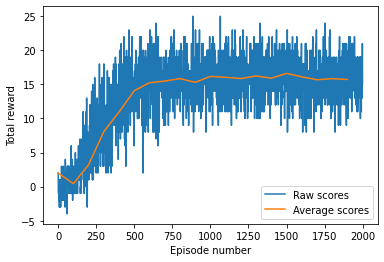

In [6]:
do_train = True

#######################
### HYPERPARAMETERS ###
#######################
# As you can see, it takes a village of hyperparameters to get many RL algorithms working well

# Training parameters
NUM_EPISODES = 2000         # Total number of episodes to train
AVERAGE_WINDOW = 100        # Number of episodes to compute average reward
MAX_EPISODE_STEPS = 10000   # Maximum number of steps per episode
LEARN_PERIOD = 4            # Number of simulation steps between running a training step
BATCH_SIZE = 64             # Training batch size (sampled from replay buffer)
REPLAY_BUFFER_SIZE = 200000 # Number of experiences in replay buffer for sampling at training time

# Reinforcement Learning parameters
GAMMA = 0.999               # Discount factor
TAU = 1e-3                  # Update rate for the target network

# Learning rate parameters
LEARN_RATE = 1e-3               # Base learning rate
LEARN_RATE_DECAY_FACTOR = 0.25  # Stepwise factor for learning rate
LEARN_RATE_DECAY_PERIOD = 500   # Number of episodes before stepping down learning rate

# Exploration vs. exploitation parameters (epsilon = probability of randomly picking action)
EPS_INIT = 0.5                            # Initial value of epsilon
EPS_FINAL = 0.05                          # Final (and minimum) value of epsilon
EPS_DECAY_STEPS = int(0.9*NUM_EPISODES)   # Number of episodes over which epsilon is linearly decayed to its minimum

# Random seed for reproducibility
RANDOM_SEED = 0

### END HYPERPARAMETERS ###


# Create the agent and learning rate decay scheduler
agent = DQNAgent(action_size=action_size, learn_rate=LEARN_RATE, learn_period=LEARN_PERIOD, 
                 batch_size=BATCH_SIZE, replay_buffer_size=REPLAY_BUFFER_SIZE,
                 gamma=GAMMA, tau=TAU, seed=RANDOM_SEED)
lr_decay = optim.lr_scheduler.StepLR(agent.optimizer, 
    step_size=LEARN_RATE_DECAY_PERIOD, gamma=LEARN_RATE_DECAY_FACTOR)

# Train the agent
if do_train:
    epsilon = EPS_INIT
    scores = []
    scores_avg = []
    scores_window = deque(maxlen=AVERAGE_WINDOW)
    for idx in range(NUM_EPISODES):

        # Start the episode by resetting the environment
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        done = False
        score = 0

        # Run the episode to completion
        t_step = 0
        while not done:
            # Get the next action from the agent using the epsilon-greedy policy
            action = agent.get_action(state, epsilon)

            # Step the environment and unpack the information
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0] 

            # Step the agent and learning rate scheduler
            agent.step(state, action, reward, next_state, done)

            # Update the next state and score
            state = next_state
            score += reward
            t_step += 1
            if t_step >= MAX_EPISODE_STEPS:
                break

        # Once the episode is done, decay epsilon and learning rate
        epsilon = max(EPS_FINAL, epsilon - (EPS_INIT-EPS_FINAL)*(idx/EPS_DECAY_STEPS))
        lr_decay.step()

        # Update the average scores
        scores.append(score)
        scores_window.append(score)
        if idx % AVERAGE_WINDOW == 0:
            mean_score = np.mean(scores_window)
            scores_avg.append(mean_score)
            print("\rAverage score at episode {}: {}".format(idx, mean_score))

    ### End training loop ###
            
    # Plot the final scores
    fig = plt.figure()
    plt.plot(np.arange(len(scores)), scores)
    plt.plot(np.arange(len(scores_avg))*AVERAGE_WINDOW, scores_avg)
    plt.xlabel("Episode number")
    plt.ylabel("Total reward")
    plt.legend(["Raw scores", "Average scores"])
    plt.show()
    
    # Save the trained agent to file
    torch.save(agent.qnetwork_local.state_dict(),"trained_weights.pth")

# Else load a pretrained model
else:
    trained_agent = torch.load("trained_weights.pth")
    agent.qnetwork_local.load_state_dict(trained_agent)

### 5. Test the Trained Agent

Now we will run the environment with the trained agent using a fully greedy policy (epsilon=0) and compare it to the earlier run in which the agent took purely random actions.

In [7]:
# Reset the environment
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]
score = 0

# Run the trained agent until the end of the episode
done = False
while not done:
    # Get an action with the agent, using the fully greedy policy
    action = agent.get_action(state, 0)            
    
    # Then, step the agent using this action
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    score += reward
    state = next_state
    
# Now compare the final scores with random actions and with the trained agent
print("Score with random agent: {}".format(random_score))
print("Score with trained agent: {}".format(score))

Score with random agent: 0.0
Score with trained agent: 17.0
